In [ ]:
import pandas as pd

# Input and output file paths
input_parquet_file = 'train-00000-of-00001.parquet'
output_csv_file = 'output_file.csv'

# Read the Parquet file into a Pandas DataFrame
df = pd.read_parquet(input_parquet_file)

# Save the DataFrame as a CSV file
df.to_csv(output_csv_file, index=False)

print(f"File '{input_parquet_file}' has been converted to CSV format and saved as '{output_csv_file}'.")


File 'train-00000-of-00001.parquet' has been converted to CSV format and saved as 'output_file.csv'.


In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
import re

# Load the Hugging Face pipeline for Zero-Shot classification
zero_shot_classifier = pipeline("zero-shot-classification")

# Function to get Hugging Face response for Zero-Shot classification
def get_huggingface_response(prompt, model="facebook/bart-large-mnli", temperature=0.7):
    result = zero_shot_classifier(prompt, candidate_labels=["correct", "incorrect", "complete", "incomplete", "comprehensive", "incomplete"])
    return result['scores'][0]  # Return the score for the most likely label

# Function to compute correctness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_correctness_score(description, disease_term, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate how similar the disease term is to the description
    zero_shot_prompt = f"Evaluate the correctness of the disease description in relation to the disease term. The description: '{description}' and the disease term: '{disease_term}'. Rate the correctness on a scale from 0 to 1."

    correctness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return correctness_score_zero_shot


# Function to compute completeness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_completeness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate if the description covers all aspects of the disease
    zero_shot_prompt = f"Is the following disease description complete? Does it include key symptoms, diagnostic information, and relevant details about the disease? Describe any missing aspects. The description: '{description}'"

    completeness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return completeness_score_zero_shot


# Function to compute comprehensiveness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_comprehensiveness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate the comprehensiveness of the description
    zero_shot_prompt = f"Is the following disease description comprehensive? Does it include symptoms, diagnostic tests, treatments, and all relevant details? Rate the comprehensiveness on a scale from 0 to 1. The description: '{description}'"

    comprehensiveness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return comprehensiveness_score_zero_shot


# Few-shot Prompting Example for Correctness, Completeness, and Comprehensiveness
def few_shot_prompt(prompt, model="gpt2"):
    # Example 1: Correctness
    example_1 = "Description: 'A condition characterized by joint pain and stiffness. Often causes inflammation.' Disease Term: 'Arthritis'. Correctness: 0.8"
    example_2 = "Description: 'A disorder affecting the nervous system with symptoms of paralysis and muscle weakness.' Disease Term: 'Multiple Sclerosis'. Correctness: 0.9"

    # Example 2: Completeness
    example_3 = "Description: 'A disease caused by the flu virus, characterized by fever, chills, sore throat, and fatigue.' Completeness: 0.8"
    example_4 = "Description: 'A chronic condition involving high blood sugar levels and insulin resistance.' Completeness: 0.9"

    # Example 3: Comprehensiveness
    example_5 = "Description: 'A condition that involves an autoimmune response that attacks the joints.' Comprehensiveness: 0.7"
    example_6 = "Description: 'A mental health condition characterized by persistent sadness, feelings of hopelessness, and a lack of interest in daily activities.' Comprehensiveness: 0.85"

    # Combine the examples and prompt
    few_shot_examples = "\n".join([example_1, example_2, example_3, example_4, example_5, example_6])

    prompt_with_few_shot = f"{few_shot_examples}\n\n{prompt}"

    # Use the GPT-2 model from Hugging Face for Few-Shot Prompting
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForCausalLM.from_pretrained(model)

    inputs = tokenizer(prompt_with_few_shot, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=400, num_return_sequences=1, temperature=0.7)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the numerical score from the response
    match = re.search(r"(\d+\.\d+)", response)
    if match:
        return float(match.group(1))  # Return the extracted score
    else:
        return 0.0  # Return a default score in case no score is found


# Read the CSV file using pandas (replace 'your_file.csv' with the actual file path)
csv_file_path = 'output_file.csv'  # Replace this with your actual CSV file path
df = pd.read_csv(csv_file_path)

# Initialize variables to accumulate scores for averaging
zero_shot_correctness_total = 0
zero_shot_completeness_total = 0
zero_shot_comprehensiveness_total = 0

few_shot_correctness_total = 0
few_shot_completeness_total = 0
few_shot_comprehensiveness_total = 0

# Evaluate the first few rows of the CSV file
num_rows = 7
for i in range(num_rows):
    description = df.iloc[i]['text']  # Adjust the column name accordingly
    disease_term = df.iloc[i]['label']  # Adjust the column name accordingly

    # Compute the scores using Zero-Shot and Few-Shot approaches

    # Zero-Shot Approach
    correctness_score_zero_shot = compute_correctness_score(description, disease_term)
    completeness_score_zero_shot = compute_completeness_score(description)
    comprehensiveness_score_zero_shot = compute_comprehensiveness_score(description)

    zero_shot_correctness_total += correctness_score_zero_shot
    zero_shot_completeness_total += completeness_score_zero_shot
    zero_shot_comprehensiveness_total += comprehensiveness_score_zero_shot

    print(f"Row {i+1} - Zero-Shot Correctness Score: {correctness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Completeness Score: {completeness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Comprehensiveness Score: {comprehensiveness_score_zero_shot}")

    # Few-Shot Approach
    few_shot_correctness_prompt = f"Evaluate the correctness of the disease description: '{description}' with the disease term: '{disease_term}'. Rate the correctness from 0 to 1."
    few_shot_completeness_prompt = f"Is the following disease description complete? Rate the completeness from 0 to 1. The description: '{description}'"
    few_shot_comprehensiveness_prompt = f"Evaluate if the description includes symptoms, diagnostic tests, and treatments. Rate the comprehensiveness from 0 to 1. The description: '{description}'"

    correctness_score_few_shot = few_shot_prompt(few_shot_correctness_prompt)
    completeness_score_few_shot = few_shot_prompt(few_shot_completeness_prompt)
    comprehensiveness_score_few_shot = few_shot_prompt(few_shot_comprehensiveness_prompt)

    few_shot_correctness_total += correctness_score_few_shot
    few_shot_completeness_total += completeness_score_few_shot
    few_shot_comprehensiveness_total += comprehensiveness_score_few_shot

    print(f"Row {i+1} - Few-Shot Correctness Score: {correctness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Completeness Score: {completeness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Comprehensiveness Score: {comprehensiveness_score_few_shot}")

# Calculate and print the average scores for Zero-Shot and Few-Shot
zero_shot_correctness_avg = zero_shot_correctness_total / num_rows
zero_shot_completeness_avg = zero_shot_completeness_total / num_rows
zero_shot_comprehensiveness_avg = zero_shot_comprehensiveness_total / num_rows

few_shot_correctness_avg = few_shot_correctness_total / num_rows
few_shot_completeness_avg = few_shot_completeness_total / num_rows
few_shot_comprehensiveness_avg = few_shot_comprehensiveness_total / num_rows

print(f"\nZero-Shot Average Correctness Score: {zero_shot_correctness_avg}")
print(f"Zero-Shot Average Completeness Score: {zero_shot_completeness_avg}")
print(f"Zero-Shot Average Comprehensiveness Score: {zero_shot_comprehensiveness_avg}")

print(f"\nFew-Shot Average Correctness Score: {few_shot_correctness_avg}")
print(f"Few-Shot Average Completeness Score: {few_shot_completeness_avg}")
print(f"Few-Shot Average Comprehensiveness Score: {few_shot_comprehensiveness_avg}")


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Row 1 - Zero-Shot Correctness Score: 0.2984800934791565
Row 1 - Zero-Shot Completeness Score: 0.4353615939617157
Row 1 - Zero-Shot Comprehensiveness Score: 0.32834190130233765


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 1 - Few-Shot Correctness Score: 0.8
Row 1 - Few-Shot Completeness Score: 0.8
Row 1 - Few-Shot Comprehensiveness Score: 0.8
Row 2 - Zero-Shot Correctness Score: 0.27995988726615906
Row 2 - Zero-Shot Completeness Score: 0.45225250720977783
Row 2 - Zero-Shot Comprehensiveness Score: 0.33088964223861694


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 2 - Few-Shot Correctness Score: 0.8
Row 2 - Few-Shot Completeness Score: 0.8
Row 2 - Few-Shot Comprehensiveness Score: 0.8
Row 3 - Zero-Shot Correctness Score: 0.3069274425506592
Row 3 - Zero-Shot Completeness Score: 0.4567423462867737
Row 3 - Zero-Shot Comprehensiveness Score: 0.36996200680732727


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 3 - Few-Shot Correctness Score: 0.8
Row 3 - Few-Shot Completeness Score: 0.8
Row 3 - Few-Shot Comprehensiveness Score: 0.8
Row 4 - Zero-Shot Correctness Score: 0.2944944500923157
Row 4 - Zero-Shot Completeness Score: 0.4603099524974823
Row 4 - Zero-Shot Comprehensiveness Score: 0.37586668133735657


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 4 - Few-Shot Correctness Score: 0.8
Row 4 - Few-Shot Completeness Score: 0.8
Row 4 - Few-Shot Comprehensiveness Score: 0.8
Row 5 - Zero-Shot Correctness Score: 0.2944944500923157
Row 5 - Zero-Shot Completeness Score: 0.4603099524974823
Row 5 - Zero-Shot Comprehensiveness Score: 0.37586668133735657


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 5 - Few-Shot Correctness Score: 0.8
Row 5 - Few-Shot Completeness Score: 0.8
Row 5 - Few-Shot Comprehensiveness Score: 0.8
Row 6 - Zero-Shot Correctness Score: 0.303938090801239
Row 6 - Zero-Shot Completeness Score: 0.45283010601997375
Row 6 - Zero-Shot Comprehensiveness Score: 0.35967233777046204


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 6 - Few-Shot Correctness Score: 0.8
Row 6 - Few-Shot Completeness Score: 0.8
Row 6 - Few-Shot Comprehensiveness Score: 0.8
Row 7 - Zero-Shot Correctness Score: 0.29617834091186523
Row 7 - Zero-Shot Completeness Score: 0.44243043661117554
Row 7 - Zero-Shot Comprehensiveness Score: 0.3510487377643585


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 7 - Few-Shot Correctness Score: 0.8
Row 7 - Few-Shot Completeness Score: 0.8
Row 7 - Few-Shot Comprehensiveness Score: 0.8

Zero-Shot Average Correctness Score: 0.2963532507419586
Zero-Shot Average Completeness Score: 0.451462413583483
Zero-Shot Average Comprehensiveness Score: 0.3559497126511165

Few-Shot Average Correctness Score: 0.7999999999999999
Few-Shot Average Completeness Score: 0.7999999999999999
Few-Shot Average Comprehensiveness Score: 0.7999999999999999


In [2]:
import pandas as pd
from tqdm import tqdm

# Function to extract unique pairs of label and text
def get_unique_pairs(df):
    unique_pairs = set()  # Store unique pairs in a set to avoid duplicates
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Entries"):
        pair = (row['label'], row['text'])
        unique_pairs.add(pair)
    return unique_pairs

# Function to calculate uniqueness and duplication scores
def calculate_scores(df):
    unique_pairs = get_unique_pairs(df)
    total_entries = len(df)
    unique_pairs_count = len(unique_pairs)

    # Calculate scores
    uniqueness_score = unique_pairs_count / total_entries
    duplication_score = 1 - uniqueness_score  # Duplication score is the complement of uniqueness

    return uniqueness_score, duplication_score

# Load the dataset
dataset_path = 'output_file.csv'
df = pd.read_csv(dataset_path)

# Calculate and print the scores for the dataset
uniqueness_score, duplication_score = calculate_scores(df)
print(f"Uniqueness Score: {uniqueness_score:.4f}")
print(f"Duplication Score: {duplication_score:.4f}")


Processing Entries: 100%|██████████| 23516/23516 [00:02<00:00, 10325.49it/s]

Uniqueness Score: 0.8886
Duplication Score: 0.1114


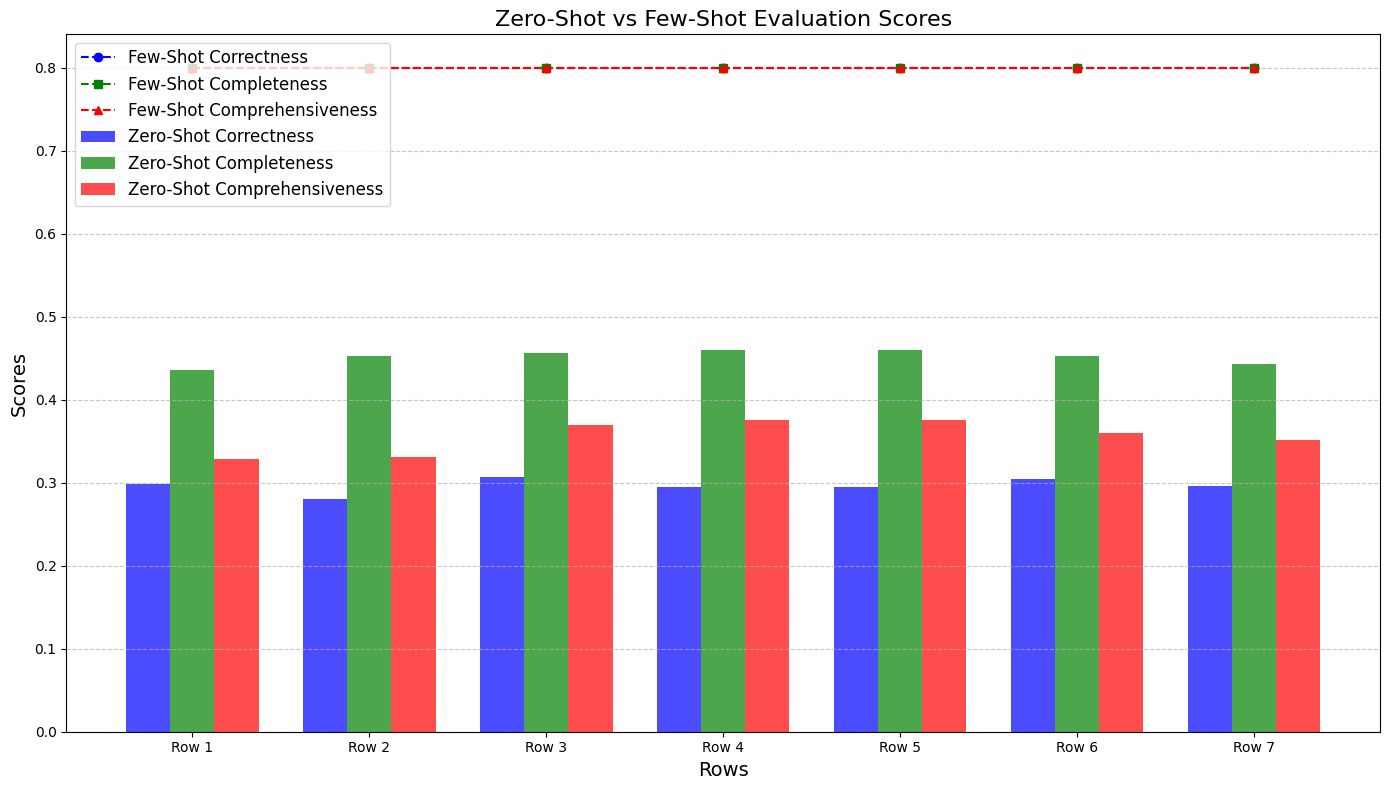

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
rows = [f"Row {i+1}" for i in range(7)]  # Rows 1 to 7
zero_shot_correctness = [0.2984800934791565, 0.27995988726615906, 0.3069274425506592,
                         0.2944944500923157, 0.2944944500923157, 0.303938090801239, 0.29617834091186523]
zero_shot_completeness = [0.4353615939617157, 0.45225250720977783, 0.4567423462867737,
                          0.4603099524974823, 0.4603099524974823, 0.45283010601997375, 0.44243043661117554]
zero_shot_comprehensiveness = [0.32834190130233765, 0.33088964223861694, 0.36996200680732727,
                               0.37586668133735657, 0.37586668133735657, 0.35967233777046204, 0.3510487377643585]

few_shot_correctness = [0.8] * 7
few_shot_completeness = [0.8] * 7
few_shot_comprehensiveness = [0.8] * 7

# Bar width for grouped bar charts
bar_width = 0.25

# X positions for bars
x = np.arange(len(rows))

# Visualization
plt.figure(figsize=(14, 8))

# Zero-shot visualization
plt.bar(x - bar_width, zero_shot_correctness, width=bar_width, label='Zero-Shot Correctness', color='blue', alpha=0.7)
plt.bar(x, zero_shot_completeness, width=bar_width, label='Zero-Shot Completeness', color='green', alpha=0.7)
plt.bar(x + bar_width, zero_shot_comprehensiveness, width=bar_width, label='Zero-Shot Comprehensiveness', color='red', alpha=0.7)

# Few-shot visualization
plt.plot(x, few_shot_correctness, marker='o', label='Few-Shot Correctness', color='blue', linestyle='--')
plt.plot(x, few_shot_completeness, marker='s', label='Few-Shot Completeness', color='green', linestyle='--')
plt.plot(x, few_shot_comprehensiveness, marker='^', label='Few-Shot Comprehensiveness', color='red', linestyle='--')

# Adding labels and legend
plt.xticks(x, rows)
plt.xlabel("Rows", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.title("Zero-Shot vs Few-Shot Evaluation Scores", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()
